In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

/var/folders/2x/955c2pcd1cld0_8tfm105_pm0000gn/T/ipykernel_5893/4160649604.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("../data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [3]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
len(np.unique(data['Artist Name'])), len(np.unique(data['Track Name']))

(9149, 15129)

It seems to be strange to predict Classes according to artist and track names. In music, many artists create music in specific genre, so we actually would not need other data to predict the genre (class) here. I will try to build a model without this parameters.

In this dataset we observe 3 columns containing NaN: key, popularity, instrumentallness. Further I will perform imputations for these missing values. It seems that it is a good idea to perform KNN and linear models to fill the NAs, but I am now in business trip in Novosibirsk and, unfortunately, do not have enough time, so I will perform imputation wih medians.

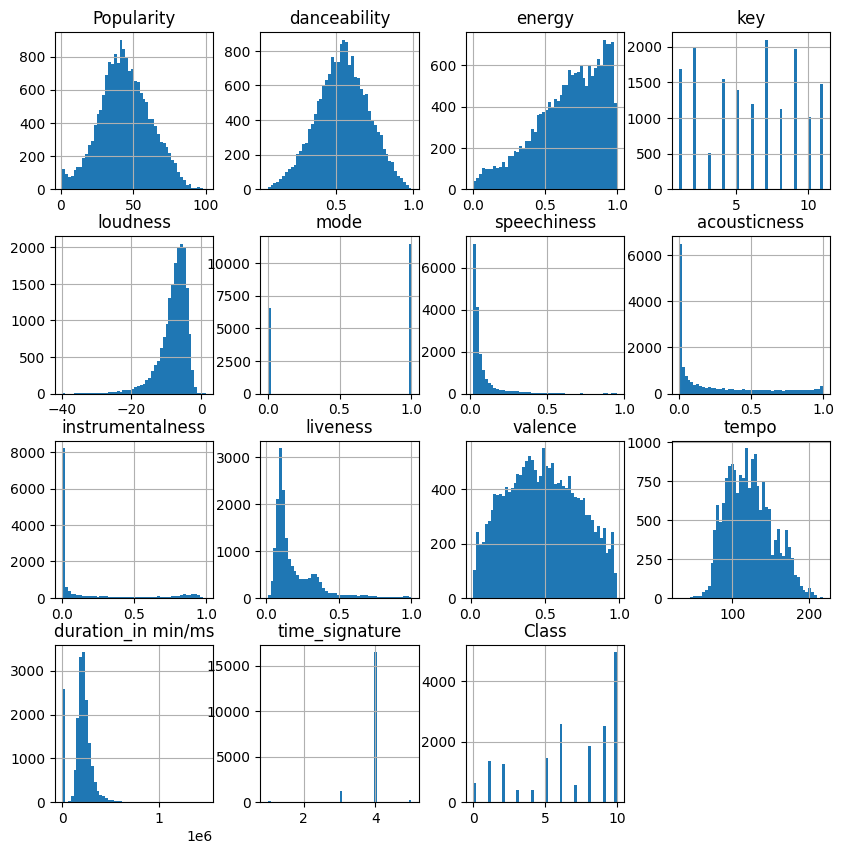

In [6]:
data.hist(bins=50, figsize=(10,10))
plt.show();

The distribution of several columns seems to be okay: Popularity, danceability, valency, tempo, energy. Several strange values in duration - it should be checked. Mode, key, time_signature are categorical. 

Firstly, I will check values in duration column

In [7]:
min(data['duration_in min/ms'])
max(data['duration_in min/ms'])

1477187.0

The range of the column is very high, but according to the boxplot, there are no significant outliers which could be dropped out.

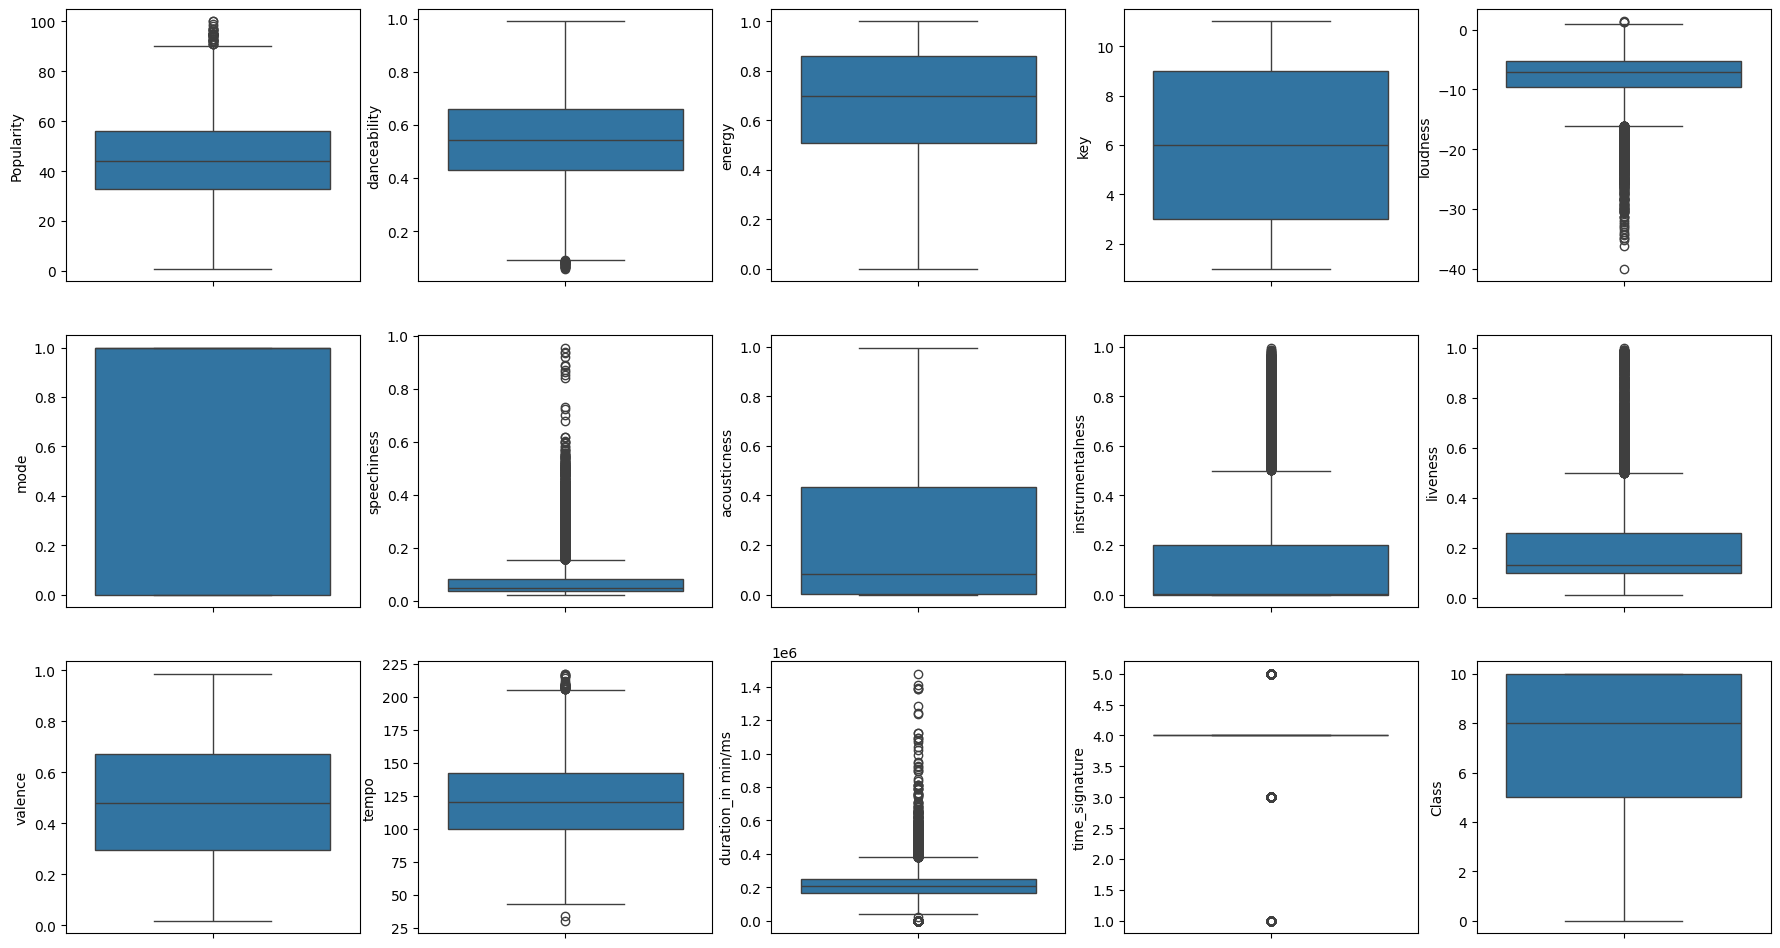

In [8]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

fig = plt.figure(figsize=(22, 12))

for i in range(1, 16):
    fig.add_subplot(3, 5, i)
    sns.boxplot(data.select_dtypes(include=numerics)[data.select_dtypes(include=numerics).columns[i-1]])
plt.show()

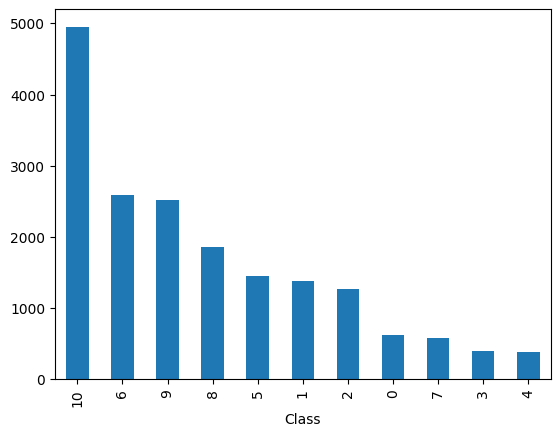

In [9]:
data['Class'].value_counts().plot(kind='bar');

Actually, we can see that 10th Class have 10 times more observations than Classes 3 and 4. Classes are highly imbalanced.

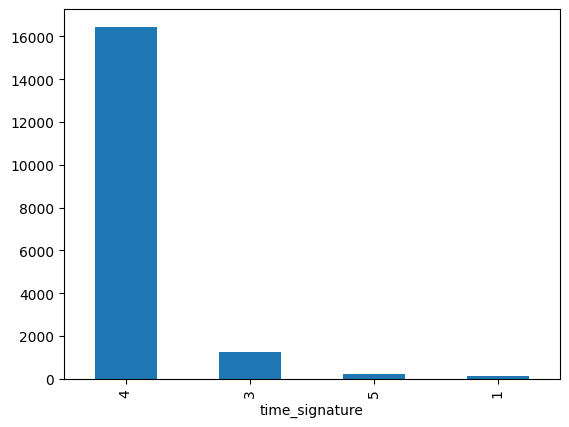

In [10]:
data['time_signature'].value_counts().plot(kind='bar');

This feature has veeeery strong imbalance towards 4. Maybe there are more powerful methods to wark with such features, but here I will just delete it.

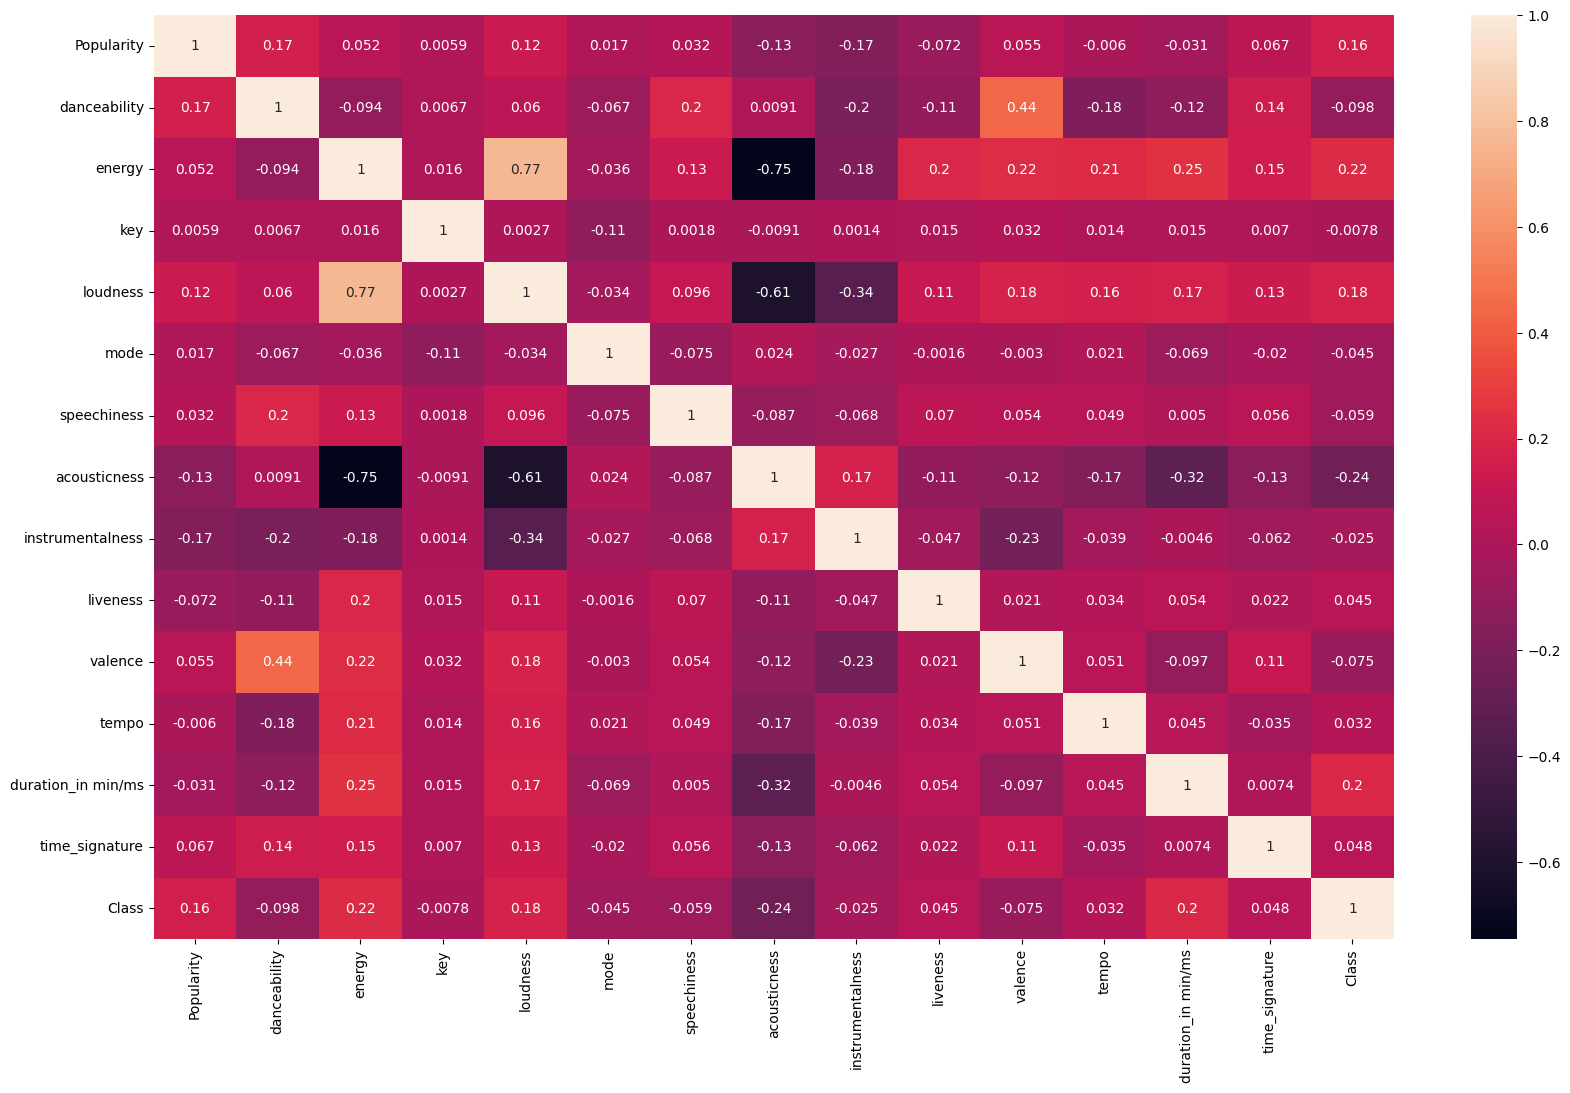

In [11]:
plt.figure(figsize=(20, 12))
sns.heatmap(data.select_dtypes(include=np.number).corr(), 
            annot=True); ## <-- ADDED

There are high correlations between acousticness, loudness and energy. 

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [12]:
X = data.drop(columns=['Artist Name', 'Track Name', 'Class', 'time_signature'])
y = data[['Class']]

#### Imputation

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

X_imp = imputer.fit_transform(X)

X_df = pd.DataFrame(X_imp, columns=X.columns)

#### OneHotEncoding

In [14]:
X_end_imp = pd.get_dummies(X_df, columns=['key'])


#### Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_end_imp, 
                                                    y, 
                                                    test_size = 0.3,
                                                    stratify = y, 
                                                    random_state=111)

#### GridSearch

Initially, I have entered these parameters for the GridSearch, but the waiting was too long. So I had to decrease the number of parameters.

tree_classifier = DecisionTreeClassifier(random_state=111)

scoring = {'AUC':'roc_auc_ovr', 'Accuracy':'accuracy', 'F1_macro':'f1_macro', 'F1_weighted':'f1_weighted'}

parapaparams = {'criterion':['gini', 'entropy'],
                'max_depth': list(range(1,20)),
                'min_samples_split': [2, 3, 5, 7, 13, 19, 23, 29],
                'min_samples_leaf': [1, 3, 5, 7, 9],
                'class_weight':['balanced', None]}

grid_search = GridSearchCV(estimator = tree_classifier, param_grid = parapaparams, cv=10, scoring = scoring, refit = False)

grid_search.fit(X_train, y_train)

In [16]:
tree_classifier = DecisionTreeClassifier(random_state=111)

parapaparams = {'max_depth': list(range(7,20, 2)),
                'min_samples_split': [2, 3, 5, 7, 13, 19, 23, 29],
                'min_samples_leaf': [1, 3, 5, 7, 9]}

grid_search = GridSearchCV(estimator = tree_classifier, param_grid = parapaparams, cv=5, scoring = 'f1_macro')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=111),
             param_grid={'max_depth': [7, 9, 11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 3, 5, 7, 13, 19, 23, 29]},
             scoring='f1_macro')

In [17]:
grid_search.best_params_

{'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 23}

In [18]:
tree_classifier_best = DecisionTreeClassifier(max_depth=11, min_samples_leaf=7, min_samples_split=23, random_state=111)

tree_classifier_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=7, min_samples_split=23,
                       random_state=111)

In [19]:
y_pred = tree_classifier_best.predict(X_test)

#### Metrics

In [20]:
f'Accuracy: {round(accuracy_score(y_test, y_pred), 2)}, Precision: {round(precision_score(y_test, y_pred, average="macro"), 2)}, Recall: {round(recall_score(y_test, y_pred, average="macro"), 2)}, F1: {round(f1_score(y_test, y_pred, average="macro"), 2)}'

'Accuracy: 0.48, Precision: 0.53, Recall: 0.52, F1: 0.51'

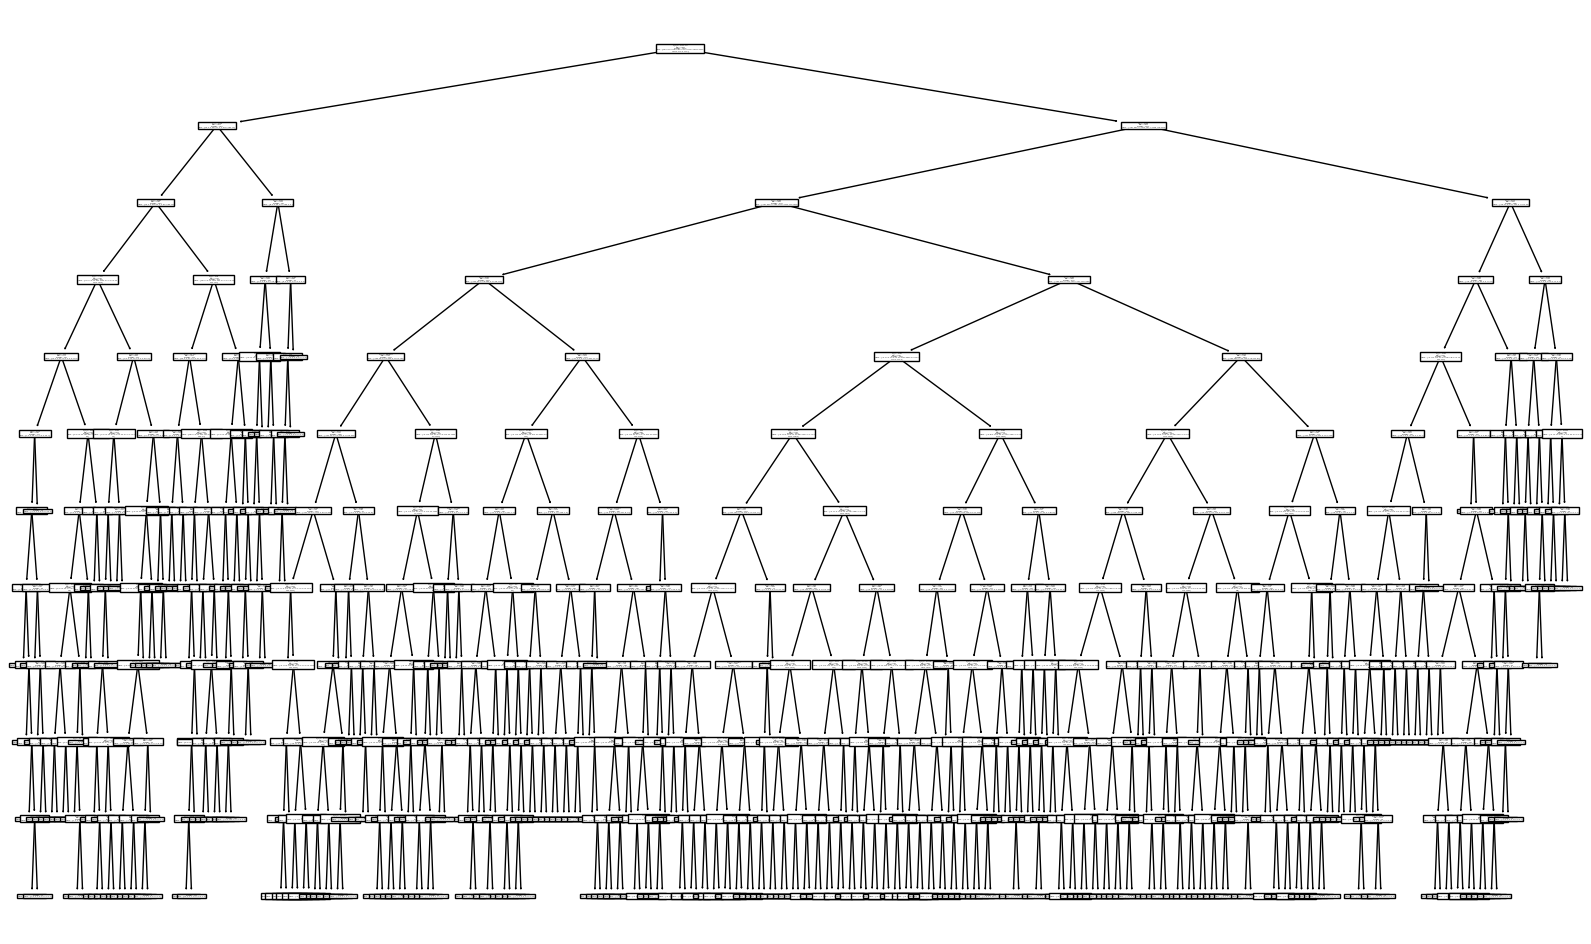

In [22]:
plt.figure(figsize=(20, 12)
plot_tree(tree_classifier_best);

I suppose that with better tuning of GridSearch as I wanted to perform at the beginning, I would be able to find better parameters. But anyway, one decision tree is not a good way to predict. Here I choose 4 metrics as you can see and actually I do not see the difference between them. 

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. The Big Bang Theory

2. Spirited Away (Hayao Miyazaki)

3. The Secret Life of Walter Mitty